In [1]:
import mturk
import random
from datetime import datetime
import json
from pprint import pprint
import copy
import numpy as np
from collections import OrderedDict
import pandas as pd
import pymongo
import botocore
import uuid
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import krippendorff_alpha as ka

In [2]:
with open('./config/mongodb_credentials.json','r') as f:
    mongodb_credentials = json.load(f)

In [3]:
""" Connect to MTurk and to the Mongodb database. Set the boolean below to TRUE to use the marketplace and to FALSE to use the sandbox (testing the HITs)"""
create_hits_in_production = True
is_pilot = True

db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
db = db_client['verbalisations']

collection_name = 'hit_results' + ('_sandbox' if not create_hits_in_production else '') + ('_pilots' if is_pilot else '')

hit_result_collection = db[collection_name]
hit_result_collection

Collection(Database(MongoClient(host=['cluster0-shard-00-02.hjstc.mongodb.net:27017', 'cluster0-shard-00-00.hjstc.mongodb.net:27017', 'cluster0-shard-00-01.hjstc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', ssl=True), 'verbalisations'), 'hit_results_pilots')

# Analysing Pilot results

Remember to reward good feedback

- Roberta: Since the nature of your task can be confusing, **add more examples so that we have something to look upon when we’re stuck on something difficult**, **provide an accessible link that we can open in another tab and take a look at if and when necessary and compare the sentences with the ones from the real task**. It would be great if you could **stick with just English language** but I’m not sure what are you trying to prove here, maybe you need the foreign languages to prove your point, you got the last word about it.

In [4]:
from pprint import pprint
batch_pipeline = [
    {
        '$project': {
            'batch_id': 1, 
            'type': 1, 
            'scale': 1, 
            'hit': 1, 
            'timestamp': 1
        }
    }, {
        '$group': {
            '_id': '$batch_id', 
            'type': {
                '$max': '$type'
            }, 
            'scale': {
                '$max': '$scale'
            }, 
            'timestamp': {
                '$min': '$timestamp'
            }, 
            'ids': {
                '$addToSet': '$_id'
            }, 
            'reward': {
                '$avg': {
                    '$toDouble': '$hit.Reward'
                }
            }
        }
    }, {
        '$addFields': {
            'count': {
                '$size': '$ids'
            }
        }
    }
]
pprint(list(hit_result_collection.aggregate(batch_pipeline)))

[{'_id': 'd2ba6b1d-c4ea-4648-af1f-6a1d4daa8c9b',
  'count': 15,
  'ids': ['3SA4EMRVKYE8W1SFOJGOI01CPQE0PW',
          '36818Z1KW6PXQPLAINGAU3AOTGY3AE',
          '3HEA4ZVWWGY3YYWX1ADM1PSMFYO550',
          '3I7SHAD36P8GT9VMH295GBH4SZ97M7',
          '3BAWBGQGZOBZJWPVVUAW370HJSKV7B',
          '3G3AJKPCYO4J432HY7Z97UK1A7WY43',
          '3RBI0I35YHFYM7JDYTUQXPSVW70Y3I',
          '3CMIQF80HQ2OAOF9QLBUR61D7PLQ6D',
          '3PMR2DOWPRDL2FSXN5UCWXM8F2T54V',
          '30U1YOGZHD8Z8D91SC8DSCQ66ZTSDW',
          '3LCXHSGDMWI40JN1O7JXYU8R6BUSEP',
          '3VO4XFFP28Y7EOTE9VGMXK19205Q7C',
          '3D4BBDG70K8LJ4I821C10Y0CTJJ3CG',
          '3S8A4GJRE6FGFWBQCK54XT0LOH0V6C',
          '36FQTHX306329ZQ2O1G6PEUUBYJ3B9'],
  'reward': 1.0,
  'scale': None,
  'timestamp': datetime.datetime(2021, 8, 5, 17, 43, 40, 324000),
  'type': 'adequacy'},
 {'_id': '265c1c45-a816-4830-90c8-f0cbfbdeddcc',
  'count': 15,
  'ids': ['3BCRDCM0PG62ZLHEDGRXVKP49Y8K6P',
          '3HEM8MA6ICOWKUXE5HA3X6SU39QPQS',


### Batch ids

#### First run

30 tasks, 15 fluench and 15 adequacy, analysing a total of 58 non-gd and 6 gd verbalisations, 5 hits each.

Fluency batch id: 4a617a3a-2792-4cf4-8798-12f542dcd84b
    
Adequacy batch id: d2ba6b1d-c4ea-4648-af1f-6a1d4daa8c9b

#### Second run

30 tasks, 15 fluench and 15 adequacy, analysing a total of 58 non-gd and **16** gd verbalisations, 5 hits each. (We have added 10 gold standard questions with very bad to bad (levels 0-3) fluency and bad adequacy (No or Not Sure).

Fluency batch id: 265c1c45-a816-4830-90c8-f0cbfbdeddcc
    
Adequacy batch id: 30aafea2-d17b-438c-a646-302286f4cb68

In [5]:
pilot_flu = list(hit_result_collection.find(
    {'type':'fluency', 'batch_id' : {
        '$in' : ['265c1c45-a816-4830-90c8-f0cbfbdeddcc', '4a617a3a-2792-4cf4-8798-12f542dcd84b']
    }}))
pilot_ade = list(hit_result_collection.find(
    {'type':'adequacy', 'batch_id' : {
        '$in' : ['30aafea2-d17b-438c-a646-302286f4cb68', 'd2ba6b1d-c4ea-4648-af1f-6a1d4daa8c9b']
    }}))
len(pilot_flu), len(pilot_ade)

(30, 30)

### Other Adequacy reasons

In [6]:
reason_no_other = []
reason_not_sure_other = []
for hit in pilot_ade:
    for answer in hit['answers']:
        for output in answer['values']['outputs']:
            if output['reason_no_other'] != '':
                reason_no_other.append(output['reason_no_other'])
            if output['reason_not_sure_other'] != '':
                reason_not_sure_other.append(output['reason_not_sure_other'])

In [7]:
reason_no_other

['Cause of the "North American" in the triple.',
 'It matches according to the triple, but adding "(mountain)" and "(theatre company)" in the actual sentence after the names would help clarify a ton.',
 "Because Shizuka is a child, but the triple is saying Kozue is the child (since she's the object.)",
 "The years don't match up from the object and the cathedral isn't mentioned by name at all.",
 'I think that the subject and the object in the triple are swapped.']

In [8]:
reason_not_sure_other

["the subject doesn't seem to be using an object that explains it and the sentence is both grammatically incorrect and incoherent. ",
 "It's not an actual sentence, it's something grabbed from a table of contents"]

### Completion time

In [9]:
df_pilot_times = pd.DataFrame(columns=['type','time'])

for hit in pilot_flu:
    for answer in hit['answers']:
        df_pilot_times = df_pilot_times.append({'type':'fluency', 'time': np.sum(answer['values']['times'])/1000}, ignore_index=True)

print(df_pilot_times[df_pilot_times['type'] == 'fluency']['time'].mean(), 'seconds is the mean fluency time')
print(df_pilot_times[df_pilot_times['type'] == 'fluency']['time'].median(), 'seconds is the median fluency time')

for hit in pilot_ade:
    for answer in hit['answers']:  
        df_pilot_times = df_pilot_times.append({'type':'adequacy', 'time': np.sum(answer['values']['times'])/1000}, ignore_index=True)


print(df_pilot_times[df_pilot_times['type'] == 'adequacy']['time'].mean(), 'seconds is the mean adequacy time')
print(df_pilot_times[df_pilot_times['type'] == 'adequacy']['time'].median(), 'seconds is the median adequacy time')

193.5675133333333 seconds is the mean fluency time
98.637 seconds is the median fluency time
349.0253733333332 seconds is the mean adequacy time
216.065 seconds is the median adequacy time


In [10]:
# According to median values, pay should be
MINIMUM_HOURLY_USD_WAGE = 7.25
# Fluency
AVG_HIT_TIME_SECONDS = df_pilot_times[df_pilot_times['type'] == 'fluency']['time'].median()
AVG_HIT_TIME_HOURS = AVG_HIT_TIME_SECONDS/3600
print('Fluency:', AVG_HIT_TIME_HOURS*MINIMUM_HOURLY_USD_WAGE)
# Adequacy
AVG_HIT_TIME_SECONDS = df_pilot_times[df_pilot_times['type'] == 'adequacy']['time'].median()
AVG_HIT_TIME_HOURS = AVG_HIT_TIME_SECONDS/3600
print('Adequacy:', AVG_HIT_TIME_HOURS*MINIMUM_HOURLY_USD_WAGE)

# I have then decided to pay 0.50 for Fluency and 1.00 for Adequacy, which is above minimum wage.

Fluency: 0.19864395833333331
Adequacy: 0.4351309027777778


In [11]:
df_pilot_times.sort_values('time')#.head(100)

,type,time
156,adequacy,17.372
21,fluency,20.732
50,fluency,22.973
178,adequacy,25.207
3,fluency,27.079
...,...,...
78,fluency,2293.485
260,adequacy,2410.744
269,adequacy,2502.854
148,fluency,2685.014


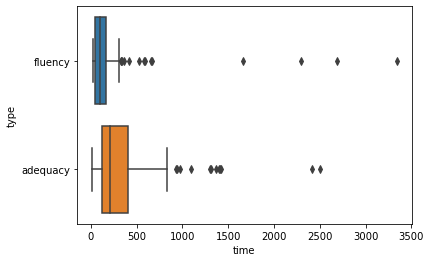

In [12]:
g = sns.boxplot(data = df_pilot_times, x='time', y='type')
g.set_xscale("linear")

### Feedback

In [13]:
from pprint import pprint
for p in pilot_flu:
    print(p['_id'])
    for a in p['answers']:
        if a['values']['feedback'] != None :
            print(a['worker_id'], '-', a['values']['feedback'], '-', a['assignment_id'])
    print('-----')
    print('\n')

3UEDKCTPAY2L3LVJWQWP1YP03UE7K2
A3BHKF9NJKCXPB - Very informative - 3Y5140Z9D1SMQG7PIBAWDOX0BORPIC
-----


3ZXNP4Z3AUXWNRD1HQ8QGY2FSUJ7L5
A2BNQ8VAMP3ZYO - no - 3I7DHKZYGRCYNFNGXOVXCLFR4W4F5V
A10NBQP7W50X1I - Nice - 386CSBG1O3YRX8D3GNGWGQX57TDQ65
A1AWR7C38PW42P - Very interesting - 39N5ACM9HIZTFFEMEH4J0VYXSY9P9Y
A3MG9XS4W3FGOA - nice - 39GXDJN2OXQ66US8V1746RS4UGQV8Y
-----


3O71U79SSE12C7FE557GB2D0FDLMS8
-----


38XPGNCKIWC2097CTWCP0VG7SQUV4R
A2LGYV57X9WMCD - very interesting - 3WLEIWSYHSTQ2EVZAVHZHZOS01H2H6
A2BR2FSQ3O82TL - very interesting - 3KGTPGBS61XV701JAUOY0EDIUAU2UK
-----


3VZYA8PIURA43RAW447AKUWVYQD50F
A3NTNVS05946M0 - Nice - 37QW5D2ZRKYQE2B4162ZV48XVCPS8J
A3Q9UK9RCL87O8 - Nice - 3A1COHJ8NN71OTXOQCQ0RQ1VM1E8HK
-----


3K3G488TS5KSRKFVL21PZ0NDBUAQ5X
AIIN7IRYDQ0QE - GOOD SURVEY - 3KRVW3HTZRX5ZRD8V7CI0M9SFHCSM5
A3KOWY3F88WP94 - very nice - 3AUQQEL7U95OO5N50XUPDCMMBJK0VO
A9LXSGXZM4IJE - Nice - 3GGAI1SQEZAPSAOCYLMILH5ATEQMC5
-----


3ULIZ0H1WDH4AGVE0NBAYZF53IJ51I
A1QEUI0J88TO78 - go

In [14]:
from pprint import pprint
for p in pilot_ade:
    print(p['_id'])
    for a in p['answers']:
        if a['values']['feedback'] != None :
            print(a['worker_id'], '-', a['values']['feedback'], '-', a['assignment_id'])
    print('-----')
    print('\n')

3RBI0I35YHFYM7JDYTUQXPSVW70Y3I
A1KOBLL83SICGQ - Very interesting and educating study - 3BXQMRHWK3ALE45CKC7IFNRG0FPMU9
-----


3SA4EMRVKYE8W1SFOJGOI01CPQE0PW
AIIN7IRYDQ0QE - GOOD SURVEY - 31QTRG6Q2XP8GGMUMTWZZCRO17JYPL
ASBVFTDEA883R - very nice and more informative - 340UGXU9D2D44RZLY4892JATR8XVUV
AA9Y4BEMJYWN1 - nice experiment I really enjoyed it. - 32Z9ZLUT1PW49LK4XTFWOCRV19XOHO
-----


3I7SHAD36P8GT9VMH295GBH4SZ97M7
A2949EJ4EVG6LM - this task seems interesting to do - 3NC5L260MSYKVPTY23RWLRFILRYOFY
A1BAT5O7WVAFPW - Very nice - 3180JW2OT8OESH9CGEMIRJ7JX5NJ58
A3SLY0SJLJZ0J1 - good job - 3I0BTBYZA1X5SZIA58H9KBQGT2TY06
-----


3PMR2DOWPRDL2FSXN5UCWXM8F2T54V
A3JV9OXFPCVOF1 - good - 34BBWHLWHENCAP4QUXOR5I5W4LPIWV
A1J6B5XUULEITY - Thanks. - 3PPTZCWALUWTLIXEISD7DOQ0CYNZQK
A3AJE1ORZMFDON - Very nice - 3MD9PLUKKMQ8ILKM20LQ9UVV7N0NZL
A32KY6ARWL8W3E - nice - 3PZDLQMM0XXZL6KJO33Y68RCNAQ2CD
-----


3S8A4GJRE6FGFWBQCK54XT0LOH0V6C
A1KL6MRIHQFJND - Nice - 3Z2R0DQ0JLQEI44XKU9TWWRF8LW2EX
-----


36818

### Values

In [15]:
from pprint import pprint

pilot_flu_jsons = []
for p in pilot_flu:
    for a in p['answers']:
        for i in range(6):
            pilot_flu_jsons.append({
                'claim_id': p['verbalisations'][i]['claim_id'],
                'worker_id': a['worker_id'],
                'fluency': a['values']['outputs'][i]['fluency']
            })
pilot_flu_df = pd.DataFrame(pilot_flu_jsons).sort_values('claim_id')

pilot_ade_jsons = []
for p in pilot_ade:
    for a in p['answers']:
        for i in range(6):
            pilot_ade_jsons.append({
                'claim_id': p['verbalisations'][i]['claim_id'],
                'worker_id': a['worker_id'],
                'adequacy': a['values']['outputs'][i]['adequacy']
            })
pilot_ade_df = pd.DataFrame(pilot_ade_jsons).sort_values('claim_id')

In [29]:
pd.concat([pilot_flu_df.worker_id, pilot_ade_df.worker_id]).unique().shape

(181,)

In [34]:
pilot_flu_df.shape[0] + pilot_ade_df.shape[0]

1800

Minimum mean fluency per worker: 1.8333333333333333
maximum mean fluency per worker: 4.833333333333333


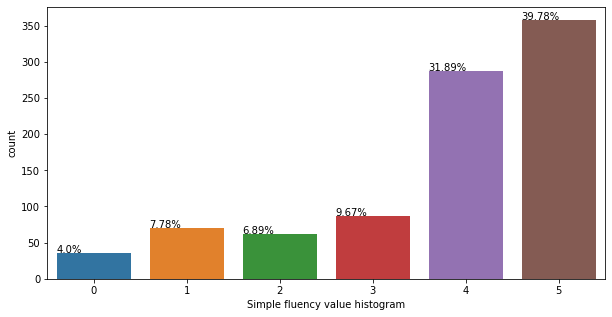

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

perc = pilot_flu_df.fluency.value_counts(normalize=True).mul(100).rename('percent')
g = sns.countplot(data=pilot_flu_df, x='fluency', ax=ax)
for p in g.patches:
    txt = str((p.get_height()/pilot_flu_df.shape[0]*100).round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)
ax.set(xlabel = 'Simple fluency value histogram')

print('Minimum mean fluency per worker:', pilot_flu_df.groupby('worker_id').mean()['fluency'].min())
print('maximum mean fluency per worker:', pilot_flu_df.groupby('worker_id').mean()['fluency'].max())

<AxesSubplot:xlabel='fluency'>

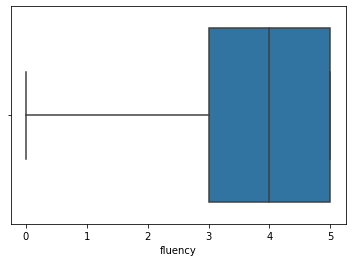

In [13]:
sns.boxplot(data=pilot_flu_df, x='fluency')

Minimum mean fluency per worker: 1.8333333333333333
maximum mean fluency per worker: 4.833333333333333


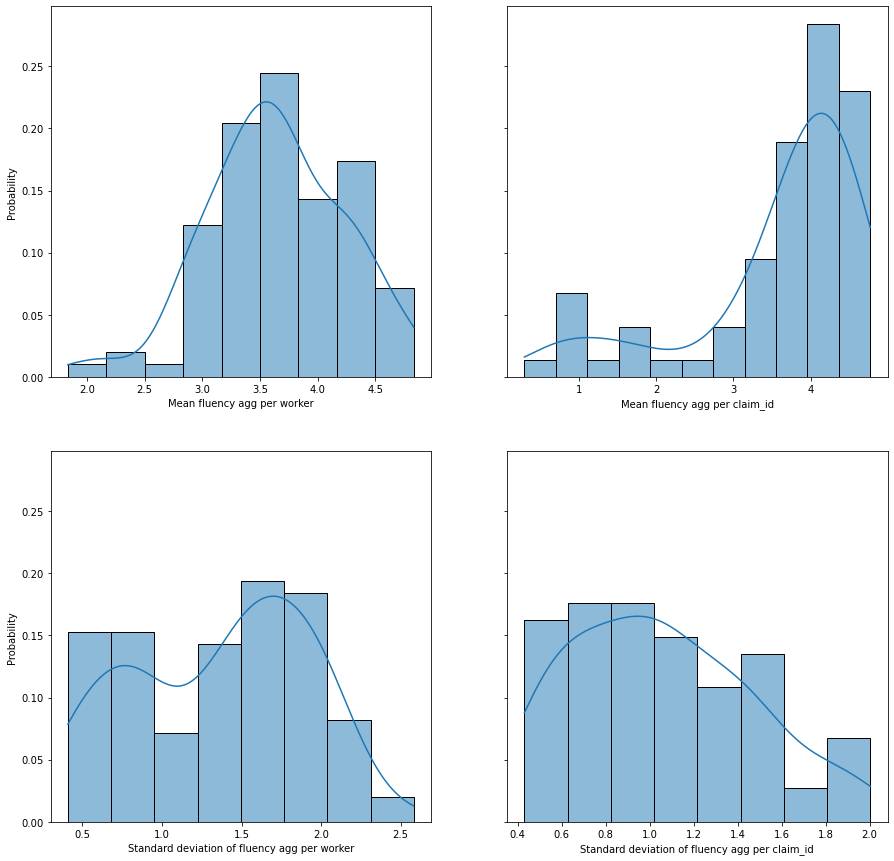

In [14]:
fig, ax = plt.subplots(2,2,figsize=(15,15), sharey=True, sharex=False)

g = sns.histplot(data = pilot_flu_df.groupby('worker_id').mean(), x='fluency', ax=ax[0][0], kde=True, stat='probability')
ax[0][0].set(xlabel = 'Mean fluency agg per worker')

g = sns.histplot(data = pilot_flu_df.groupby('worker_id').std(), x='fluency', ax=ax[1][0], kde=True, stat='probability')
ax[1][0].set(xlabel = 'Standard deviation of fluency agg per worker')

g = sns.histplot(data = pilot_flu_df.groupby('claim_id').mean(), x='fluency', ax=ax[0][1], kde=True, stat='probability')
ax[0][1].set(xlabel = 'Mean fluency agg per claim_id')

g = sns.histplot(data = pilot_flu_df.groupby('claim_id').std(), x='fluency', ax=ax[1][1], kde=True, stat='probability')
ax[1][1].set(xlabel = 'Standard deviation of fluency agg per claim_id')

print('Minimum mean fluency per worker:', pilot_flu_df.groupby('worker_id').mean()['fluency'].min())
print('maximum mean fluency per worker:', pilot_flu_df.groupby('worker_id').mean()['fluency'].max())

### Agreement

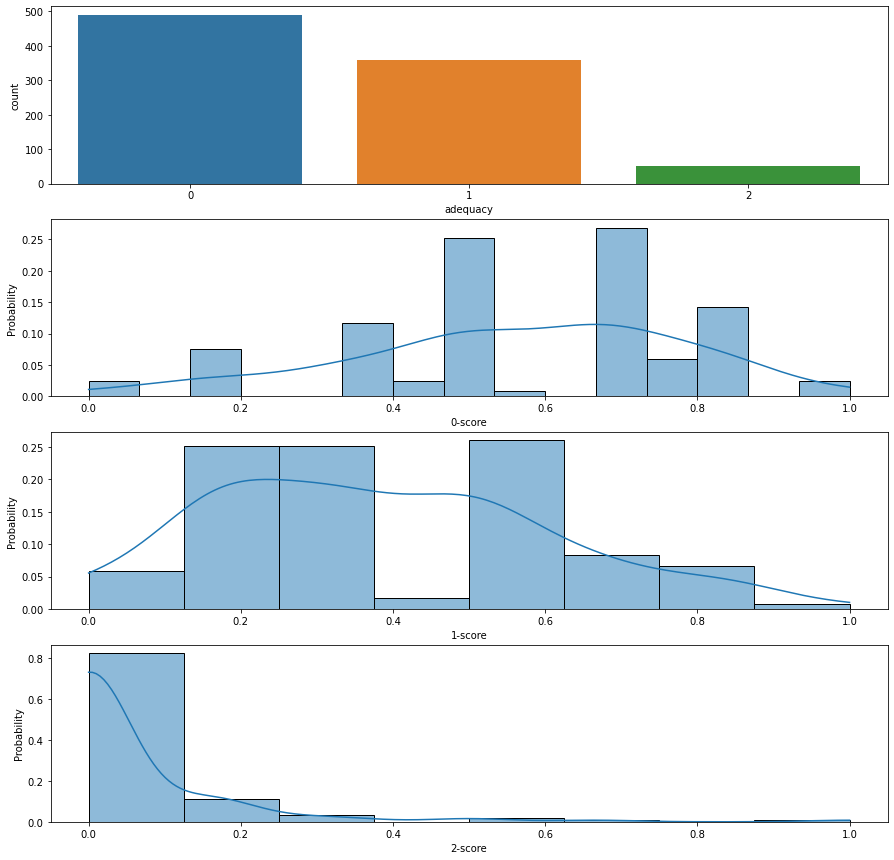

In [15]:
pilot_ade_df_worker = pilot_ade_df.groupby('worker_id')['adequacy'].apply(list).reset_index()
pilot_ade_df_worker['0-score'] = pilot_ade_df_worker.adequacy.apply(lambda x : x.count(0)/len(x))
pilot_ade_df_worker['1-score'] = pilot_ade_df_worker.adequacy.apply(lambda x : x.count(1)/len(x))
pilot_ade_df_worker['2-score'] = pilot_ade_df_worker.adequacy.apply(lambda x : x.count(2)/len(x))

fig, ax = plt.subplots(4,1,figsize=(15,15))

sns.countplot(data=pilot_ade_df, x='adequacy', ax=ax[0])
sns.histplot(data = pilot_ade_df_worker, ax=ax[1], kde=True, x = '0-score', stat='probability')
sns.histplot(data = pilot_ade_df_worker, ax=ax[2], kde=True, x = '1-score', stat='probability')
sns.histplot(data = pilot_ade_df_worker, ax=ax[3], kde=True, x = '2-score', stat='probability')


plt.show()

In [16]:
def prep_for_kripp(df, col, fun=np.min, fillna = None):
    '''
    WE TAKE THE MIN HERE, UNDER THE PREMISE THAT IF A WORKER SAW THE SAME SENTENCE TWICE AND GAVE IT TWO SCORES,
    THE LESSER SCORE WOULD REFLECT DIFFICULTIES THE WORKER HAD THAT MIGHT NOT HAVE BEEN ON THEIR MIND DURING THE
    GREATER SCORE ASSIGNMENT, BUT THAT ARE REAL NONETHELESS AND MUST BE REPORTED
    '''
    df = df.copy()
    df = df[['worker_id','claim_id',col]].groupby(['worker_id','claim_id']).agg(fun).reset_index()
    df = df.pivot(index='worker_id',columns='claim_id',values=col)
    if fillna:
        df = df.fillna('*')
    return df

def prep_for_fleiss(df, col):
    df = df.copy()    
    df = df[['claim_id',col]]
    df['count'] = 1
    df = df.groupby(['claim_id',col]).sum().reset_index()
    df = df.pivot(index='claim_id', columns=col, values='count').fillna(0)
    df = df[df.apply(lambda x : sum(x) == 5.0, axis=1)]
    return df

def prep_for_icc(df):
    df = df.copy()   
    ref_count = df['claim_id'].value_counts().reset_index()
    not_repeated = list(ref_count[ref_count['claim_id'] == 5]['index'])

    df = df[df['claim_id'].apply(lambda x : x in not_repeated)]
    df = df.sort_values('claim_id')
    df['raters'] = ['A','B','C','D','E']*(df.shape[0]//5)
    return df

In [17]:
df = pd.DataFrame({
  "a": [5,   5,    5,    5,    5],
  "b": [5,   5,    4,    5,    4],
  "c": ['*', 5,   '*', '*',    5],
  "d": [5,   5,    3,    5,  '*'],
  "e": [5, '*',    5,    4,    5],
  "f": [5,   3,    5,    4,    5],
}).T
ka.krippendorff_alpha(df.values, ka.interval_metric, missing_items='*')

# WHILE DISTRIBUTIONS LIKE THE ONE ABOVE SCORE VERY LOW, FLIPPING 3s AND 5s IN THE SECOND COLUMN, WHICH
# SHOULD NOT CHANGE AGREEMENT, ACTUALLY INCREASES IT A LOT (0.37)
# AND CHANGING IT TO [1,2,3,4,*,5] WHICH SHOULD DECREASE AGREEMENT ACTUALLY INCREASES IT TOO (to 0.34)

# THE ISSUE HERE, AFTER TALKING WITH EDDY, IS THE LACK OF ANNOTATION VARIABILITY. THERE IS NO INDICATION THAT PEOPLE
# CAN RATE ANYTHING OTHER THAN 5,4 AND 3, AND THE SPREAD SEEMS TO FAVOUR 5 SO THAT IT IS EXPECTED THAT THINGS WILL 
# MOSTLY BE A 5

-0.06779661016949157

In [18]:
pilot_flu_df['fluency+'] = pilot_flu_df.fluency.apply(lambda x : 0 if x < 3 else 1)
pilot_ade_df['adequacy+'] = pilot_ade_df.adequacy.apply(lambda x : 0 if x == 0 else 1)

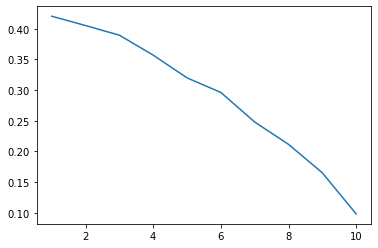

In [19]:
X = list(range(1,11))
Y = []

for i in X:
    y = []
    for _ in range(10):
        ii = random.sample(range(1,11), i)
        claim_id_ii = ['NOT_FLUENT_GOLDEN_DATA_' + str(j).rjust(2,'0') for j in ii]

        pilot_flu_df_ii = pilot_flu_df.copy()
        pilot_flu_df_ii = pilot_flu_df_ii[pilot_flu_df_ii['claim_id'].apply(lambda x : x not in claim_id_ii)]

        pilot_flu_df_kripp = prep_for_kripp(pilot_flu_df_ii, 'fluency',fillna='*')

        y.append(ka.krippendorff_alpha(
            pilot_flu_df_kripp.values, ka.interval_metric, missing_items='*'
        ))
    Y.append(np.mean(y))
plt.plot(X,Y)

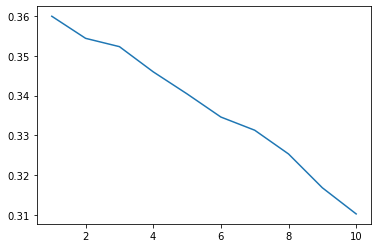

In [20]:
X = list(range(1,11))
Y = []

for i in X:
    y = []
    for _ in range(10):
        ii = random.sample(range(1,11), i)
        claim_id_ii = ['NOT_FLUENT_GOLDEN_DATA_' + str(j).rjust(2,'0') for j in ii]

        pilot_ade_df_ii = pilot_ade_df.copy()
        pilot_ade_df_ii = pilot_ade_df_ii[pilot_ade_df_ii['claim_id'].apply(lambda x : x not in claim_id_ii)]

        pilot_ade_df_kripp = prep_for_kripp(pilot_ade_df_ii, 'adequacy',fillna='*')

        y.append(ka.krippendorff_alpha(
            pilot_ade_df_kripp.values, ka.nominal_metric, missing_items='*'
        ))
    Y.append(np.mean(y))
plt.plot(X,Y)

In [21]:
import krippendorff_alpha as ka 
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss

aggr_levels_relevancy = {}

aggr_levels_relevancy['fluency'] = {}

pilot_flu_df_kripp = prep_for_kripp(pilot_flu_df, 'fluency',fillna='*')
pilot_flu_df_fleiss = prep_for_fleiss(pilot_flu_df,'fluency')
#pilot_flu_df_icc = prep_for_icc(pilot_flu_df)

aggr_levels_relevancy['fluency']['kalpha'] = ka.krippendorff_alpha(
    pilot_flu_df_kripp.values, ka.interval_metric, missing_items='*'
)
aggr_levels_relevancy['fluency']['fkappa'] = fleiss(pilot_flu_df_fleiss)
aggr_levels_relevancy['fluency']['rkappa'] = fleiss(pilot_flu_df_fleiss, method = 'rand')
#aggr_levels_relevancy['fluency']['icc'] = pg.intraclass_corr(
#    data = pilot_flu_df_icc, targets = 'claim_id',raters='raters',ratings='fluency'
#)


aggr_levels_relevancy['adequacy'] = {}

pilot_ade_df_kripp = prep_for_kripp(pilot_ade_df, 'adequacy', fillna='*')
pilot_ade_df_fleiss = prep_for_fleiss(pilot_ade_df,'adequacy')
#pilot_ade_df_icc = prep_for_icc(pilot_ade_df)

aggr_levels_relevancy['adequacy']['kalpha'] = ka.krippendorff_alpha(
    pilot_ade_df_kripp.values, ka.nominal_metric, missing_items='*'
)
aggr_levels_relevancy['adequacy']['fkappa'] = fleiss(pilot_ade_df_fleiss)
aggr_levels_relevancy['adequacy']['rkappa'] = fleiss(pilot_ade_df_fleiss, method = 'rand')
#aggr_levels_relevancy['adequacy']['icc'] = pg.intraclass_corr(
#    data = pilot_ade_df_icc, targets = 'claim_id',raters='raters',ratings='adequacy'
#)

aggr_levels_relevancy

{'fluency': {'kalpha': 0.44402115491602423,
  'fkappa': -0.0937500000000001,
  'rkappa': 0.16000000000000006},
 'adequacy': {'kalpha': 0.3634322082938777,
  'fkappa': -0.11111111111111124,
  'rkappa': 0.7000000000000001}}

### Conclusion

Krippenrdorff is giving bad results due to the extreme skewing of the data. The answer I see is to introduce more cases of medium and low fluency. From the graph showed, we expect krippendorff to show a good response with 10 more non-fluent examples. We will introduce these as golden data and run the experiment again.

Upon running the experiment again with added data from "non-fluent and non-adequate" golden data examples, agreement has risen on fluency but dropped on adequacy. This is probably due to the fact that we introduced non-fluent sentences full of grammar mistakes and whose meaning is difficult to understand, while also being non-adequate, meaning they did not reflect the triple at all. This confused people as to whether to say the meaning was not there (because it wasn't) or that they weren't sure due to poor grammar and syntax (because sentences were generated through n-gram distribution emulation). However, uniting "No" and "Not Sure" under the same class, agreement also rises a lot from before. We can also report agreement with these "poor sentences" in for fluency and out for adequacy, justifying by using the original distributions from pilot run 1.

For the actual experiment, we can run with the "poor sentences" as they are now, and exclude them based on results later on, or even run a few more "poor sentences" examples later on to balance out the data if needed.

### Aggregated results

In [22]:
pilot_flu_df_agg = pilot_flu_df.copy()
pilot_flu_df_agg = pilot_flu_df_agg[pilot_flu_df_agg['claim_id'].apply(
    lambda x : not x.startswith('NOT_FLUENT_GOLDEN_DATA_')
)]
pilot_flu_df_agg = pilot_flu_df_agg.groupby('claim_id').agg(list)
pilot_flu_df_agg['fluency_mean'] = pilot_flu_df_agg['fluency'].apply(np.mean)
pilot_flu_df_agg['fluency_median'] = pilot_flu_df_agg['fluency'].apply(np.median)
pilot_flu_df_agg['fluency+_mean'] = pilot_flu_df_agg['fluency+'].apply(np.mean)
pilot_flu_df_agg['fluency+_median'] = pilot_flu_df_agg['fluency+'].apply(np.median)
pilot_flu_df_agg.head()

,worker_id,fluency,fluency+,fluency_mean,fluency_median,fluency+_mean,fluency+_median
claim_id,,,,,,,
Q105067149$991C48E5-BF5D-4B08-9ECC-7E35A5A58186,"[A2XS49LRNX8PD4, A3G3Z7XWKYE25H, A2U375YRJDHUI...","[4, 3, 4, 5, 3, 5, 1, 3, 3, 4]","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]",3.5,3.5,0.9,1.0
Q1147190$DB3A1218-A4E8-4DE8-86CE-509AB756D530,"[A1KL6MRIHQFJND, A26X8BQELDQSGH, A2E8EKAN93ZJR...","[5, 2, 5, 5, 5, 5, 5, 5, 4, 3]","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]",4.4,5.0,0.9,1.0
Q1163753$D91F5D42-3D82-42BE-80E6-307D1BA68C5A,"[A1QEUI0J88TO78, A9IYXJT90J0NK, A1BAT5O7WVAFPW...","[4, 2, 5, 4, 1, 3, 2, 3, 5, 5]","[1, 0, 1, 1, 0, 1, 0, 1, 1, 1]",3.4,3.5,0.7,1.0
Q12693708$7b6f9528-4dd1-e117-9a03-cf5359c02d36,"[A2U375YRJDHUIR, A21XMG5KSWXX9M, A30MP4LXV4MIF...","[1, 5, 5, 5, 4, 5, 5, 5, 5, 5]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",4.5,5.0,0.9,1.0
Q134015$a594cca0-5bdf-46ac-b678-1cc8d3a2e622,"[AQXEQDTAU4MJ4, A2U375YRJDHUIR, A30MP4LXV4MIFD...","[5, 4, 4, 4, 4, 5, 5, 5, 5, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]",4.1,4.5,0.9,1.0


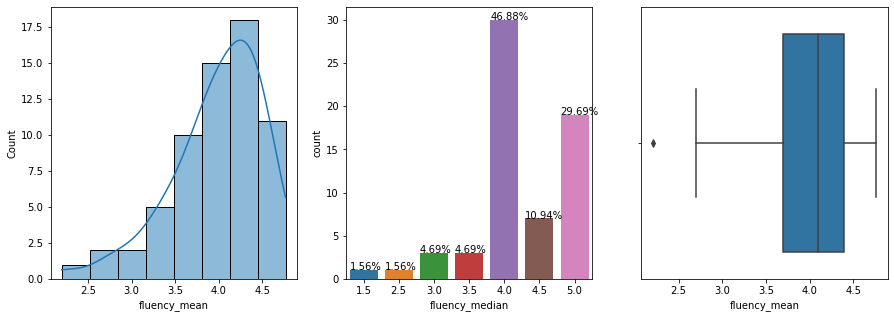

In [23]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.histplot(data=pilot_flu_df_agg, x='fluency_mean', ax=ax[0], kde=True)
g = sns.countplot(data=pilot_flu_df_agg, x='fluency_median', ax=ax[1])

for p in g.patches:
    txt = str((p.get_height()/pilot_flu_df_agg.shape[0]*100).round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)
    

sns.boxplot(data=pilot_flu_df_agg, x='fluency_mean', ax=ax[2])

plt.show()

In [24]:
from collections import Counter


def get_adequacy_majority(X):
    counts = Counter(X).most_common(3)
    if counts[0][1] > len(X)/2:
        return counts[0][0]
    else:
        highest = []
        for c in counts:
            if c[1] == counts[0][1]:
                highest.append(c)
        return np.max([c[0] for c in highest])
    
def get_adequacy_percentage(row):
    if row['adequacy_maj'] == 2:
        return 0
    else:
        return 1 - np.mean([x if x != 2 else 1 for x in row['adequacy'] ])
    
pilot_ade_df_agg = pilot_ade_df.copy()
pilot_ade_df_agg = pilot_ade_df_agg[pilot_ade_df_agg['claim_id'].apply(
    lambda x : not x.startswith('NOT_FLUENT_GOLDEN_DATA_')
)]            
pilot_ade_df_agg = pilot_ade_df_agg.groupby('claim_id').agg(list)
pilot_ade_df_agg['adequacy_maj'] = pilot_ade_df_agg['adequacy'].apply(get_adequacy_majority)
pilot_ade_df_agg['adequacy+_maj'] = pilot_ade_df_agg['adequacy+'].apply(get_adequacy_majority)
pilot_ade_df_agg['adequacy_perc'] = pilot_ade_df_agg.apply(get_adequacy_percentage, axis=1)
pilot_ade_df_agg.head()

,worker_id,adequacy,adequacy+,adequacy_maj,adequacy+_maj,adequacy_perc
claim_id,,,,,,
Q105067149$991C48E5-BF5D-4B08-9ECC-7E35A5A58186,"[A3AD5YO7CLO4LN, A1ETG64Q7Z9MF1, A14EYTLSMJRPU...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0,0.9
Q1147190$DB3A1218-A4E8-4DE8-86CE-509AB756D530,"[AQNCH42WD4ITI, AM9HHSRDY3X37, A7EP668Z0WF6G, ...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1]","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1]",1,1,0.3
Q1163753$D91F5D42-3D82-42BE-80E6-307D1BA68C5A,"[A1CX45M5UVAM9R, A31Y7PAMZO5GVZ, A1EXO9HRNQYHW...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0,0,0.8
Q12693708$7b6f9528-4dd1-e117-9a03-cf5359c02d36,"[A14EYTLSMJRPUK, ABVPW8753ZBJO, A171SF2UF7YUN4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,1.0
Q134015$a594cca0-5bdf-46ac-b678-1cc8d3a2e622,"[A3UHRU688LVGS0, A14EYTLSMJRPUK, A171SF2UF7YUN...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 1, 0, 0, 0, 0, 1, 1, 0]",0,0,0.7


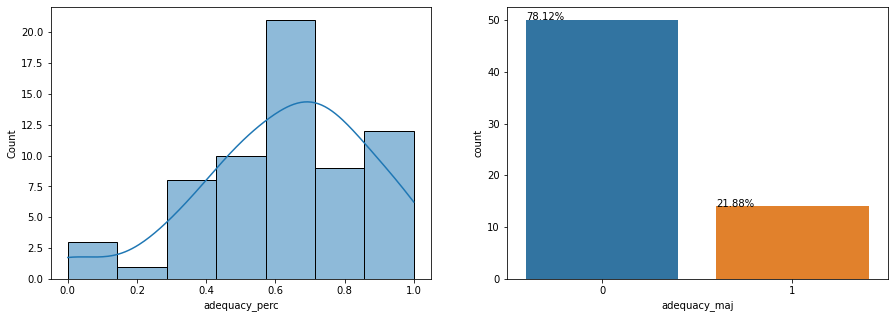

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=pilot_ade_df_agg, x='adequacy_perc', ax=ax[0], kde=True)
g = sns.countplot(data=pilot_ade_df_agg, x='adequacy_maj', ax=ax[1])

for p in g.patches:
    txt = str((p.get_height()/pilot_ade_df_agg.shape[0]*100).round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

plt.show()